In [105]:
import torch
import torchvision
from torchvision import transforms
from torch.utils import data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [106]:
train_data_path = "../data/train/"
test_data_path = "../data/test/"

In [107]:
transforms = transforms.Compose([
    transforms.Resize((128,128)),
    #transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485,0.456,0.406],
                        std = [0.229, 0.224, 0.225])
])

In [108]:
train_data = torchvision.datasets.ImageFolder(root=train_data_path, transform=transforms)
test_data = torchvision.datasets.ImageFolder(root=test_data_path, transform=transforms)

In [109]:
print("Num Images in Train Dataset:", len(train_data))
print("Num Images in Test Dataset:", len(test_data))

Num Images in Train Dataset: 3418
Num Images in Test Dataset: 373


In [110]:
batch_size=8
train_data_loader = data.DataLoader(train_data, batch_size=batch_size,num_workers=-1)
test_data_loader = data.DataLoader(test_data, batch_size=batch_size,num_workers=-1)

In [111]:
batch = next(iter(train_data_loader))

In [112]:
len(batch)

2

In [113]:
images, labels = batch

In [114]:
images.shape

torch.Size([8, 3, 128, 128])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0])


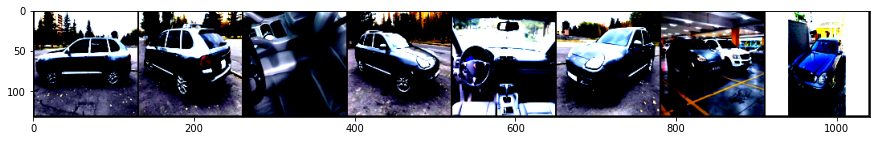

In [115]:
grid = torchvision.utils.make_grid(images, nrow=10)

plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid,(1,2,0)))
print("Labels:", labels)

In [79]:
grid.shape

torch.Size([3, 266, 872])

In [129]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=12*29*29, out_features=84)
        self.fc2 = nn.Linear(in_features=84, out_features=50)
        self.fc3 = nn.Linear(in_features=50, out_features=16)
    def forward(self, x):
        # (1) input layer
        x = x
        
        # (2) hidden conv layer
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        
        # (3) hidden conv layer
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        
        # (4) hidden linear layer
        x = x.reshape(-1, 12*29*29)
        x = self.fc1(x)
        x = F.relu(x)

        # (5) hidden linear layer
        x = self.fc2(x)
        x = F.relu(x)
        
        # (6) output layer
        x = self.fc3(x)
        # x = F.softmax(x, dim=1)
        return x
simplenet = Net()

In [130]:
sample = next(iter(train_data))

In [131]:
image,label = sample
image.shape

torch.Size([3, 128, 128])

In [132]:
image.unsqueeze(0).shape

torch.Size([1, 3, 128, 128])

In [134]:
pred = simplenet(image.unsqueeze(0))

In [138]:
pred.shape

torch.Size([1, 16])

In [139]:
pred.argmax(dim=1)

tensor([10])

#v2

In [140]:
preds = simplenet(images)

In [141]:
preds.shape

torch.Size([8, 16])

In [142]:
preds

tensor([[ 5.3923e-02,  9.1432e-02,  7.0958e-02,  8.3834e-02,  1.5400e-01,
         -1.2860e-01,  1.0263e-01,  1.4458e-01, -5.9926e-02, -3.5165e-02,
          1.6138e-01, -9.2074e-02, -4.5284e-02,  5.2267e-02,  1.7003e-02,
          5.4557e-02],
        [ 7.2250e-02,  9.5591e-02,  6.4046e-02,  9.9259e-02,  1.5465e-01,
         -1.3651e-01,  9.9719e-02,  1.4506e-01, -3.9703e-02, -3.2680e-02,
          1.5281e-01, -9.5400e-02, -4.9010e-02,  6.0427e-02, -7.4206e-03,
          4.2739e-02],
        [ 6.5451e-02,  9.4553e-02,  7.6321e-02,  9.5447e-02,  1.3997e-01,
         -1.4716e-01,  9.7151e-02,  1.4784e-01, -4.5472e-02, -3.3126e-02,
          1.6792e-01, -8.4296e-02, -2.7032e-02,  4.6821e-02,  1.6282e-04,
          5.3765e-02],
        [ 5.9514e-02,  9.4937e-02,  7.0367e-02,  8.5095e-02,  1.4776e-01,
         -1.2884e-01,  9.9275e-02,  1.5078e-01, -5.1659e-02, -3.5640e-02,
          1.6811e-01, -9.3508e-02, -4.6502e-02,  6.0481e-02,  1.6250e-02,
          5.6216e-02],
        [ 4.9863e-02

In [143]:
preds.argmax(dim=1)

tensor([10,  4, 10, 10, 10, 10, 10, 10])

In [144]:
preds.argmax(dim=1).eq(labels)

tensor([False, False, False, False, False, False, False, False])

In [145]:
optimizer = optim.Adam(simplenet.parameters(), lr=0.001)

In [146]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [147]:
def train(model, device, train_loader, optimizer, epoch, steps_per_epoch=20):
  # Switch model to training mode. This is necessary for layers like dropout, batchnorm etc which behave differently in training and evaluation mode
  model.train()
  train_total = 0
  train_correct = 0

  # We loop over the data iterator, and feed the inputs to the network and adjust the weights.
  for batch_idx, (data, target) in enumerate(train_loader, start=0):
    if batch_idx > steps_per_epoch:
      break
    # Load the input features and labels from the training dataset
    data, target = data.to(device), target.to(device)
    
    # Reset the gradients to 0 for all learnable weight parameters
    optimizer.zero_grad()
    
    # Forward pass: Pass image data from training dataset, make predictions about class image belongs to (0-9 in this case)
    output = model(data)
    
    # Define our loss function, and compute the loss
    loss = F.nll_loss(output, target)

    scores, predictions = torch.max(output.data, 1)
    train_total += target.size(0)
    train_correct += int(sum(predictions == target))
            
    # Backward pass: compute the gradients of the loss w.r.t. the model's parameters
    loss.backward()
    
    # Update the neural network weights
    optimizer.step()

  acc = round((train_correct / train_total) * 100, 2)
  print('Epoch [{}], Loss: {}, Accuracy: {}'.format(epoch, loss.item(), acc), end='')
  wandb.log({'Train Loss': loss.item(), 'Train Accuracy': acc})

In [148]:
for epoch in range(10):
  train(simplenet, device, train_data_loader, optimizer, epoch)

Epoch [0], Loss: -276.42010498046875, Accuracy: 46.43

NameError: name 'wandb' is not defined